In [759]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, root_mean_squared_error, r2_score, mean_absolute_error, make_scorer, mean_absolute_error
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import skew, norm, probplot

df = pd.read_csv('data/real_estate_belguim_features.csv', sep=',') 

# Decision tree + Random Forest

In [760]:
df.shape

(21283, 5)

In [761]:
df.head(10)

,price,longitude,prosperity_index,living_area,number_of_facades
0,289000.0,51.090212,98.0,120.0,1.0
1,259000.0,50.562261,110.0,154.0,4.0
2,429210.0,51.003447,103.0,100.0,3.0
3,314000.0,50.866522,103.0,96.0,4.0
4,229000.0,51.131602,109.0,105.0,2.0
5,359000.0,50.941781,105.0,122.0,2.0
6,260000.0,50.868935,116.0,219.0,3.0
7,375000.0,50.678788,116.0,124.0,2.0
8,340000.0,51.191459,87.0,270.0,2.0
9,345000.0,51.193722,110.0,81.0,2.0


* Apply log1p transformation to 'price' column

In [762]:
# log1p to 'price' column
#df["price"] = np.log1p(df["price"])

# Plot distribution
#sns.histplot(df['price'], kde=True, stat='density', color='blue')

# Parameters normal distribution
#(mu, sigma) = norm.fit(df['price'])
#print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot normal distribution
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, sigma)
#plt.plot(x, p, 'k', linewidth=2)
#plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
#plt.ylabel('Density')
#plt.title('SalePrice distribution')
#plt.show()

# QQ-plot
#fig = plt.figure()
#res = probplot(df['price'], plot=plt)  # Use probplot instead of stats.probplot
#plt.show()

In [763]:
# Numerical features and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude=["object"]).drop("price", axis=1).columns

df_numerical = df[numerical_features]
df_categorical = df[categorical_features]

print("Numerical features: " + str(len(numerical_features)))
print("Categorical features: " + str(len(categorical_features)))

Numerical features: 4
Categorical features: 0


In [764]:
# Find skewed features
df_numerical = df_numerical.astype(np.float64)
skewness = df_numerical.apply(lambda x: skew(x, nan_policy='omit'))
skewed_features = skewness[abs(skewness) > 0.5].index

print(f"Skewed numerical features: {len(skewed_features)}")

# Log transform the skewed numerical features 
#df_numerical[skewed_features] = df_numerical[skewed_features].apply(np.log1p)

Skewed numerical features: 2


In [765]:
# Concatenate categorical_features and numerical
categorical_features_df = df[categorical_features]
complete_features = pd.concat([df_numerical, categorical_features_df], axis=1)
complete_features.shape

(21283, 4)

In [766]:
# Apply OneHotEncoding to the categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # sparse=False ensures output is dense array
categorical_encoded = encoder.fit_transform(df_categorical)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the numerical features with the encoded categorical features
complete_features = pd.concat([df_numerical, encoded_df], axis=1)

df = pd.concat([complete_features, df['price']], axis = 1)

In [767]:
#complete_features_dummies = pd.get_dummies(complete_features,drop_first=True)
#df = pd.concat([complete_features_dummies, df['price']], axis = 1)

In [768]:
# Ordinal encoding for categorical features (random as these columns has no real order)
#for column in categorical_features_df :
#    unique_categories = complete_features[column].unique()
#    np.random.shuffle(unique_categories)  
#    category_map = {category: idx for idx, category in enumerate(unique_categories)}
#    complete_features[column] = complete_features[column].map(category_map)

# Add 'price' columns
#df = pd.concat([complete_features, df['price']], axis=1)
#df = pd.concat([complete_features, df['price']], axis=1)

In [769]:
df

,longitude,prosperity_index,living_area,number_of_facades,price
0,51.090212,98.0,120.0,1.0,289000.0
1,50.562261,110.0,154.0,4.0,259000.0
2,51.003447,103.0,100.0,3.0,429210.0
3,50.866522,103.0,96.0,4.0,314000.0
4,51.131602,109.0,105.0,2.0,229000.0
...,...,...,...,...,...
21278,50.587365,101.0,153.0,2.0,249000.0
21279,51.059134,116.0,56.0,3.0,179000.0
21280,50.212491,94.0,129.0,3.0,249000.0
21281,51.236712,106.0,201.0,2.0,429000.0


***

* Splitting the data into train and test 

In [770]:
X = df.drop('price', axis=1)
y = df['price'].values.reshape(-1,1)

print("x:", X.shape)
print("y:", y.shape)

scaler = StandardScaler()
x_transform = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=355)

x: (21283, 4)
y: (21283, 1)


#### Decision tree

In [ ]:
# Define the model
tr_regressor = DecisionTreeRegressor(
    random_state=100,
    min_samples_split=4,
    min_samples_leaf=20,
    max_leaf_nodes=405,
    max_depth=20
)

# Use cross-validation
# Define scoring metrics: Negative MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(tr_regressor, X_train, y_train, cv=5, scoring=mae_scorer)

# Convert negative scores to positive
cv_scores = -cv_scores

# Display cross-validation results
print("Cross-Validation Scores (MAE):", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
print("Standard Deviation of CV MAE:", cv_scores.std())


Cross-Validation Scores (MAE): [74513.6399408  72420.09316238 72488.76308027 71863.28999339
 72544.9538219 ]
Mean CV MAE: 72766.14799974729
Standard Deviation of CV MAE: 907.1387845354202


In [772]:
# Decision Tree Regression model
tr_regressor = DecisionTreeRegressor(random_state=100, min_samples_split=4, min_samples_leaf= 20, max_leaf_nodes=405, max_depth=20) 

# Fitting the model 
tr_regressor.fit(X_train,y_train)

# Predicting
y_pred_tr_regressor = tr_regressor.predict(X_test)

# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_tr = explained_variance_score(y_pred_tr_regressor,y_test)
print(f'Explained Variance Score: {expl_tr}')

# RMSE (Root Mean Square Error)
rmse_ = root_mean_squared_error(y_test, y_pred_tr_regressor)
print("\nRMSE: ", rmse_)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred_tr_regressor)
print("MAE: ", mae_)

# Accurancy
print('Accuracy on training set: {:3f}'.format(tr_regressor.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(tr_regressor.score(X_test,y_test)))

Explained Variance Score: 0.0681494851750224

RMSE:  95489.90687847839
MAE:  72553.45271499586
Accuracy on training set: 0.564363
Accuracy on test set: 0.489312


In [773]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth': range(5, 20),
    'max_leaf_nodes': range(10, 500, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
}
random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=100),
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=100,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 9, 'max_leaf_nodes': 190, 'max_depth': 18}


In [774]:
# Parameters used by tr_regressor
print('Parameters currently in use:\n')
print(tr_regressor.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 405, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 100, 'splitter': 'best'}


In [775]:
#plt.figure(figsize=(8,6))
#plt.scatter(y_test,y_pred_tr_regressor)
#plt.xlabel("Actual")
#plt.ylabel("Predicted")
#plt.title('Actual vs Predicted')

ValueError: x and y must be the same size

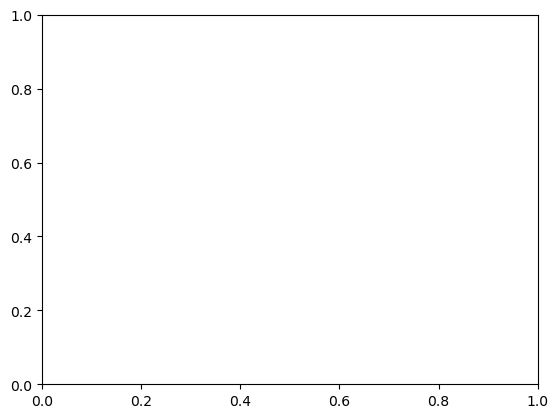

In [776]:
residuals = y_test - y_pred_tr_regressor
plt.scatter(y_pred_tr_regressor, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# 1-dimensional y_test and pred_tr
y_test_1d = y_test.ravel() if len(y_test.shape) > 1 else y_test
pred_tr_1d = y_pred_tr_regressor.ravel() if len(y_pred_tr_regressor.shape) > 1 else y_pred_tr_regressor


pred_y_df = pd.DataFrame({
    'Actual Values': y_test_1d,
    'Predicted Value': pred_tr_1d,
    'Difference': y_test_1d - pred_tr_1d
})

# Round values to 2 decimals
pred_y_df = pred_y_df.round(2)

pred_y_df[0:20]

,Actual Values,Predicted Value,Difference
0,250000.0,292795.71,-42795.71
1,675000.0,414411.56,260588.44
2,359000.0,288848.20,70151.80
3,165000.0,183699.12,-18699.12
4,99900.0,199405.66,-99505.66
5,125000.0,225267.03,-100267.03
6,340800.0,281678.05,59121.95
7,225625.0,285827.92,-60202.92
8,195000.0,307364.20,-112364.20
9,199000.0,270736.44,-71736.44


In [ ]:
# Best Tree Size

def mae(max_leaf, X_train, y_train, X_test, y_test):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf, random_state=1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return(mae)

In [ ]:
opt_max_leaf_nodes = range(5, 10000, 200)
scores = {leaf_size: mae(leaf_size, X_train, y_train, X_test, y_test) for leaf_size in opt_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)
print(f"\nBest max_leaf_nodes: {best_tree_size}")


Best max_leaf_nodes: 405


In [ ]:
# Cross Validation to choose optimal k

cv_scores = []
depth = list(range(1,15))
for k in depth:
    dtr = DecisionTreeRegressor(max_depth=k, min_samples_leaf=5)
    scores = cross_val_score(dtr, X_train, y_train, cv=10)
    cv_scores.append(scores.mean())

error = [1- x for x in cv_scores]
error

KeyboardInterrupt: 

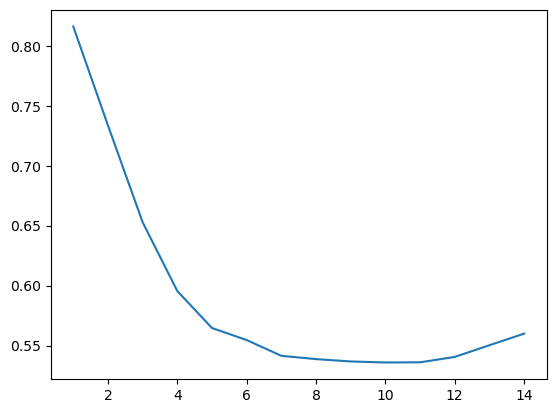

In [ ]:
plt.plot(depth, error)
plt.show()  

***

#### Random Forest Regression Model

In [ ]:
#Random Forest Regression model
rf_regressor = RandomForestRegressor(random_state=200, max_depth=9,min_samples_leaf=5)

# Fitting the model 
rf_regressor.fit(X_train,y_train)

# Predicting
y_pred_rf_regressor =rf_regressor.predict(X_test)

# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_rf = explained_variance_score(y_pred_rf_regressor,y_test)
print(f'Explained Variance Score: {expl_rf}')

# RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y_test, y_pred_rf_regressor)
print("\nRMSE: ", rmse)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred_rf_regressor)
print("MAE: ", mae_)

# Accurancy
print('Accuracy on training set: {:3f}'.format(rf_regressor.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(rf_regressor.score(X_test,y_test)))

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Explained Variance Score: -0.006685028962633455

RMSE:  93669.41281473987
MAE:  71333.96940894552
Accuracy on training set: 0.564714
Accuracy on test set: 0.508599


In [ ]:
# Parameters used by rf_regressor
print('Parameters currently in use:\n')
print(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False}


In [ ]:
#plt.figure(figsize=(8,6))
#plt.scatter(y_test,y_pred_rf_regressor)
#plt.xlabel("Actual")
#plt.ylabel("Predicted")
#plt.title('Actual vs Predicted')

In [ ]:
# 1-dimensional y_test and pred_tr
y_test_1d = y_test.ravel() if len(y_test.shape) > 1 else y_test
pred_tr_1d = y_pred_rf_regressor.ravel() if len(y_pred_rf_regressor.shape) > 1 else y_pred_rf_regressor


pred_y_df = pd.DataFrame({
    'Actual Values': y_test_1d,
    'Predicted Value': pred_tr_1d,
    'Difference': y_test_1d - pred_tr_1d
})

# Round values to 2 decimals
pred_y_df = pred_y_df.round(2)

pred_y_df[0:20]

,Actual Values,Predicted Value,Difference
0,250000.0,279315.17,-29315.17
1,675000.0,461748.21,213251.79
2,359000.0,266023.65,92976.35
3,165000.0,233303.90,-68303.90
4,99900.0,180910.20,-81010.20
5,125000.0,171358.90,-46358.90
6,340800.0,269599.30,71200.70
7,225625.0,304502.84,-78877.84
8,195000.0,280382.83,-85382.83
9,199000.0,281549.50,-82549.50


NameError: name 'tree' is not defined

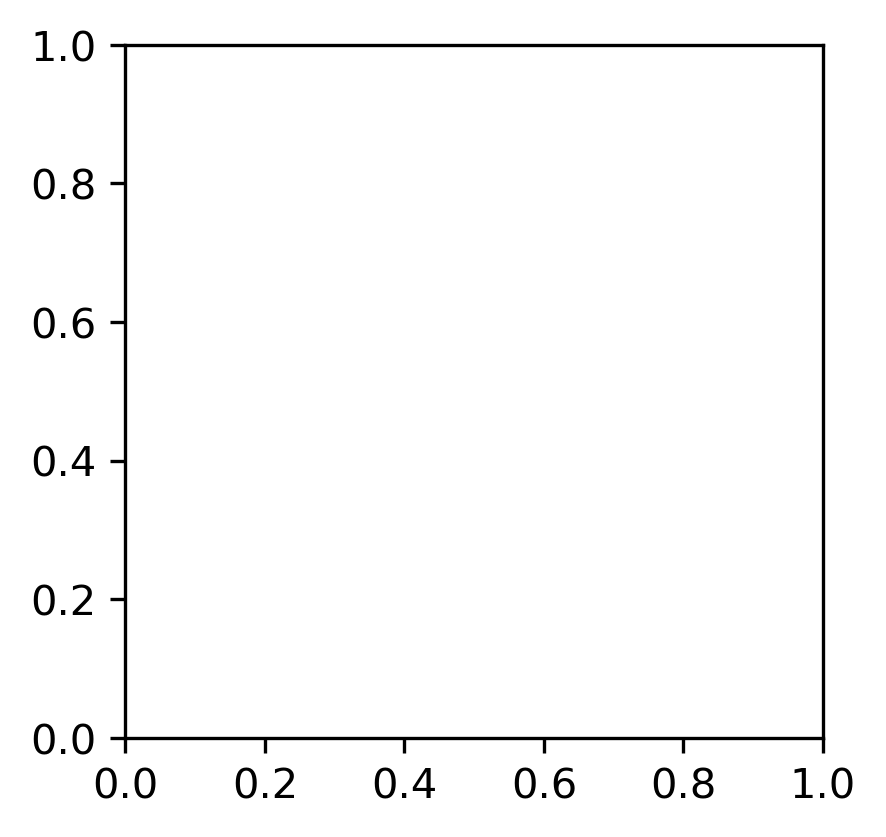

In [ ]:
# Plot a Regression Tree

fig, axes = plt.subplots(figsize=(3,3), dpi=300)   
tree.plot_tree(reg_tree, feature_names=list(X), filled = False)

plt.show()

***

# RandomForestRegressor model
model = RandomForestRegressor(random_state=10)

# Hyperparameters grid
param_grid = {
    'n_estimators': [10, 50, 100],       
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10]      
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid 
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best to predict 
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rf_reg = RandomForestRegressor(random_state=10)

param_grid = { 
    'n_estimators': [46,47,48,49,50,51,52],
    'min_samples_split': [11,12,13],
    'min_samples_leaf' : [4,5,6],
    'max_depth' : [5,6,7,8,9,10]
}

gs_rf = GridSearchCV(rf_reg, param_grid, cv= 5)
gs_rf.fit(X_train,y_train)

gs_rf.best_params_

rf_reg_best = RandomForestRegressor(random_state=10, max_depth=10, min_samples_leaf=4, min_samples_split=11, n_estimators=51)
rf_reg_best.fit(X_train, y_train)
y_pred2 = rf_reg_best.predict(X_test)

# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_rf = explained_variance_score(y_pred2,y_test)
print(f'Explained Variance Score: {expl_rf}')

# RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y_test, y_pred2)
print("\nRMSE: ", rmse)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred2)
print("MAE: ", mae_)


# Accurancy
print('Accuracy on training set: {:3f}'.format(rf_reg_best.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(rf_reg_best.score(X_test,y_test)))

***